In [306]:
import os
import allel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm
from pathlib import Path
from IPython.display import Image 
from collections import defaultdict
from intervaltree import Interval, IntervalTree
import pysam
from matplotlib.colors import ListedColormap

In [2]:
proj_dir="/master/nplatt/sch_hae_scan"
results_dir=f"{proj_dir}/results"
os.chdir(results_dir)

In [3]:
Path(f"{results_dir}/stats_minus_introgressed_alleles").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/stats_minus_introgressed_alleles")

In [4]:
pca_df=pd.read_csv(f"{proj_dir}/results/pca/pca_df.csv", sep=",")

In [6]:
#read in rfmix
df=pd.read_csv(f"{results_dir}/rfmix/rfmix_perc_bovis_genome.csv")
df

,chrom,s_pos,e_pos,s_gpos,e_gpos,n_snps,n_sb,n_sh_nw,n_sh_se,perc_sb,perc_sh_nw,perc_sh_se
0,NC_067195.1,14416,75442,0.05,0.26,582,0,156,42,1.0,0.048780,0.0
1,NC_067195.1,75442,106309,0.26,0.37,335,0,155,42,1.0,0.054878,0.0
2,NC_067195.1,106309,146168,0.37,0.51,465,0,154,42,1.0,0.060976,0.0
3,NC_067195.1,146168,156662,0.51,0.55,580,0,154,42,1.0,0.060976,0.0
4,NC_067195.1,156662,164518,0.55,0.57,885,0,155,42,1.0,0.054878,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067202.1,19335566,19381118,67.37,67.53,4950,0,159,42,1.0,0.030488,0.0
39473,NC_067202.1,19381118,19401743,67.53,67.60,2335,0,158,42,1.0,0.036585,0.0
39474,NC_067202.1,19401743,19427939,67.60,67.69,2290,0,159,42,1.0,0.030488,0.0
39475,NC_067202.1,19427939,19464116,67.69,67.82,1825,0,160,42,1.0,0.024390,0.0


In [84]:
filtered_callset=allel.read_vcf(f'{results_dir}/post_phase_filtering/chrs_unrelated.vcf')

In [85]:
gt      = allel.GenotypeArray(filtered_callset['calldata/GT'])
chroms  = filtered_callset["variants/CHROM"]
samples = filtered_callset["samples"]
poss    = filtered_callset["variants/POS"]
var_ids = filtered_callset["variants/ID"]

uniq_chroms=np.unique(chroms)

In [86]:
#get kmeans_pop_idxs

#now get an index for each sample/population
samples = list(filtered_callset["samples"])

#initiate list that will store the vcf idx for each sample in relation to the pca k group
kmeans_pop_idxs = defaultdict(lambda: [])

for sample in samples:
    idx=samples.index(sample)
    pop=pca_df.loc[pca_df["sample_name"] == sample, "kmeans_label"].values[0]
    kmeans_pop_idxs[pop].append(idx)

In [87]:
nw_acs = gt.count_alleles(subpop=kmeans_pop_idxs["sh_nw"])
se_acs = gt.count_alleles(subpop=kmeans_pop_idxs["sh_se"])

In [ ]:
fsts=[]
windows=[]
counts=[]

for chrom in uniq_chroms:
    mask = (chroms == chrom)
            
    chrom_pos    = poss[mask]
    chrom_nw_acs = nw_acs[mask]
    chrom_se_acs = se_acs[mask]
    
    coords_df = df.loc[df["chrom"] == chrom][["s_pos", "e_pos"]]
    coords = list(zip(coords_df["s_pos"], coords_df["e_pos"]))
    
    fst, window, count = allel.windowed_patterson_fst(chrom_pos, chrom_nw_acs, chrom_se_acs, windows=coords, fill=np.nan)
    
    fsts.extend(fst)
    windows.extend(window)
    counts.extend(count)
   
df["fst"]=fsts
df["window"]=windows
df["snv_count"]=counts

df.to_csv("introgression_vs_fst_df.csv", header=True, sep=",", index=False)

In [96]:
df.loc[df["snv_count"] > 100]

,chrom,s_pos,e_pos,s_gpos,e_gpos,n_snps,n_sb,n_sh_nw,n_sh_se,perc_sb,perc_sh_nw,perc_sh_se,fst,window,snv_count
0,NC_067195.1,14416,75442,0.05,0.26,582,0,156,42,1.0,0.048780,0.0,0.163176,"[14416, 75442]",583
1,NC_067195.1,75442,106309,0.26,0.37,335,0,155,42,1.0,0.054878,0.0,0.245622,"[75442, 106309]",336
2,NC_067195.1,106309,146168,0.37,0.51,465,0,154,42,1.0,0.060976,0.0,0.069989,"[106309, 146168]",466
3,NC_067195.1,146168,156662,0.51,0.55,580,0,154,42,1.0,0.060976,0.0,0.074969,"[146168, 156662]",581
4,NC_067195.1,156662,164518,0.55,0.57,885,0,155,42,1.0,0.054878,0.0,0.043141,"[156662, 164518]",886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067202.1,19335566,19381118,67.37,67.53,4950,0,159,42,1.0,0.030488,0.0,0.021582,"[19335566, 19381118]",4951
39473,NC_067202.1,19381118,19401743,67.53,67.60,2335,0,158,42,1.0,0.036585,0.0,0.023094,"[19381118, 19401743]",2336
39474,NC_067202.1,19401743,19427939,67.60,67.69,2290,0,159,42,1.0,0.030488,0.0,0.035306,"[19401743, 19427939]",2291
39475,NC_067202.1,19427939,19464116,67.69,67.82,1825,0,160,42,1.0,0.024390,0.0,0.027238,"[19427939, 19464116]",1826


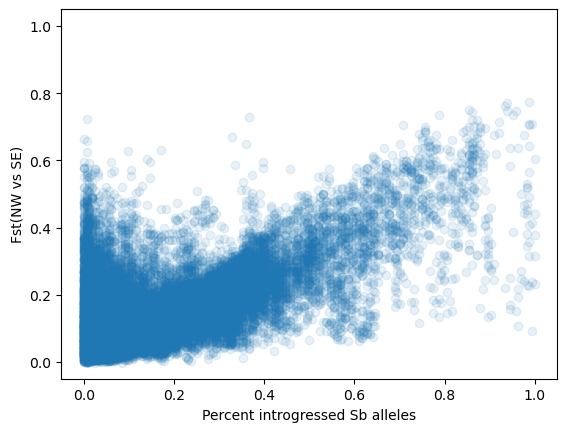

In [107]:
f_df = df.loc[df["snv_count"] > 100]
#plt.axline((0, 0), slope=1, color="black", alpha=0.7)
plt.scatter(f_df["perc_sh_nw"], f_df["fst"], alpha=0.1)
plt.ylim(-0.05,1.05)
plt.xlim(-0.05,1.05)
plt.xlabel("Percent introgressed Sb alleles")
plt.ylabel("Fst(NW vs SE)")
plt.savefig("introgression_vs_fst.png", dpi=300)
plt.savefig("introgression_vs_fst.svg")
plt.show()

# masking out introgressed regions

In [669]:
#read in rfmix table
rf_df=pd.read_csv(f"{results_dir}/rfmix/rfmix_df.csv")
rf_df

,chrom,s_pos,e_pos,s_gpos,e_gpos,n_snps,Sb_NG_au_1.2.0,Sb_NG_au_1.2.1,Sb_NG_au_2.13.0,Sb_NG_au_2.13.1,...,ssp_niger_libore_166.0,ssp_niger_libore_166.1,ssp_niger_libore_167.0,ssp_niger_libore_167.1,ssp_niger_libore_168.0,ssp_niger_libore_168.1,ssp_niger_libore_169.0,ssp_niger_libore_169.1,ssp_zambia_kafue_71.0,ssp_zambia_kafue_71.1
0,NC_067196.1,124225,212192,0.43,0.74,1302,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
1,NC_067196.1,212192,289797,0.74,1.01,860,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
2,NC_067196.1,289797,302958,1.01,1.06,645,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,NC_067196.1,302958,623463,1.06,2.17,2980,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,NC_067196.1,623463,625997,2.17,2.18,25,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067199.1,46758459,46761155,162.92,162.93,365,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
39473,NC_067199.1,46761155,46761224,162.93,162.93,15,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
39474,NC_067199.1,46761224,46762583,162.93,162.94,115,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
39475,NC_067199.1,46762583,46763230,162.94,162.94,75,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1


In [670]:
sh_samples = pca_df.loc[pca_df["pca_species"] == "s_haematobium", "sample_name"]


sh_haplotypes = [sample + suffix for sample in sh_samples for suffix in [".0", ".1"]]


intersection_cols = list(set(rf_df.columns) & set(sh_haplotypes))

# Combine the individual strings and the list from the intersection
cols_to_use = ["chrom", "s_pos", "e_pos", "n_snps"] + intersection_cols


In [671]:
to_mask_df=rf_df[cols_to_use]
to_mask_df["samples"]=None
to_mask_df

/tmp/ipykernel_244979/3350337365.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_mask_df["samples"]=None


,chrom,s_pos,e_pos,n_snps,Sh_NG_ed_3_2.0,sha_niger_libore_138.1,sha_niger_libore_147.0,Sh_NG_eb_6_2.0,sh_egypt_SRR433862.1,sha_madag_belesalampy_73.1,...,sh_cameroon_SRR13579883.1,sh_ivorycoast_SRR13579866.1,sha_sudan_schooli_129.1,sbo_niger_libore_176.0,sh_guineabissau_SRR13579870.0,sha_unguja_kinyasini_29.1,ssp_cdivoire_linguebo_100.1,sbo_cdivoire_raviart_108.0,sha_cdivoire_kongobo_115.1,samples
0,NC_067196.1,124225,212192,1302,1,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,None
1,NC_067196.1,212192,289797,860,1,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,None
2,NC_067196.1,289797,302958,645,1,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,None
3,NC_067196.1,302958,623463,2980,1,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,None
4,NC_067196.1,623463,625997,25,1,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067199.1,46758459,46761155,365,1,1,0,1,1,1,...,1,0,1,1,1,1,0,1,1,None
39473,NC_067199.1,46761155,46761224,15,1,1,0,1,1,1,...,1,0,1,1,1,1,0,1,1,None
39474,NC_067199.1,46761224,46762583,115,1,1,0,1,1,1,...,1,0,1,1,1,1,0,1,1,None
39475,NC_067199.1,46762583,46763230,75,1,1,0,1,1,1,...,1,0,1,1,1,1,0,1,1,None


In [672]:
sb_allele = 0

for index,row in to_mask_df.iterrows():
    mask_samples = ",".join(row[3:][row[3:]==sb_allele].index.tolist())
    to_mask_df.loc[index, "samples"] = mask_samples
    to_mask_df.loc[index, "e_pos"] = to_mask_df.loc[index, "e_pos+1"]

In [677]:
to_mask_df=to_mask_df[["chrom", "s_pos", "e_pos", "n_snps", "samples"]]
to_mask_df = to_mask_df.loc[to_mask_df["samples"] != '']

In [678]:
#load the masking info into a set of intervaltrees
trees = {}

# Iterate over the DataFrame rows
for index, row in tqdm(to_mask_df.iterrows()):
    # Get the chromosome name
    chrom = row["chrom"]
    start = row["s_pos"]
    stop  = row["e_pos"]
    mask_samples = row["samples"]
    
    # Initialize the interval tree for this chromosome if it doesn't exist yet
    if chrom not in trees:
        trees[chrom] = IntervalTree()
    
    # Add the interval to the tree
    trees[chrom][start:stop] = mask_samples


38563it [00:02, 15057.64it/s]


In [679]:
outfile = "autosomes_unrelated_minus_introgressed_sb.vcf"
infile  = "autosomes_unrelated_reheadered.vcf"

#outfile = "test_out.vcf"
#infile  = "test_in.vcf"

in_vcf  = pysam.VariantFile(infile)
out_vcf = pysam.VariantFile(outfile, "w", header=in_vcf.header) 

for record in tqdm(in_vcf):
    
    try:
        haps_to_mask=list(trees[record.chrom][record.pos])[0].data
        haps_to_mask=haps_to_mask.split(",")
    except:
        haps_to_mask=[]
    
    if len(haps_to_mask)>0:
        for hap_id in haps_to_mask:
            hap=hap_id.split(".")[-1]
            sample=".".join(hap_id.split(".")[:-1])

            #Set the genotype of the individual to missing based on the allele we are examining
            original_gt = record.samples[sample]['GT']

            # Create a new genotype with the first allele missing
            if hap == "0":
                new_gt = (None, original_gt[1])
            elif hap == "1":
                new_gt = (original_gt[0], None)

            # Assign the new genotype to the sample
            record.samples[sample]['GT'] = new_gt
            
    out_vcf.write(record)

out_vcf.close()
in_vcf.close()
 

28590241it [21:56, 21709.81it/s]


In [ ]:
%%bash

vcftools \
    --vcf autosomes_unrelated_minus_introgressed_sb.vcf \
    --indv sha_niger_libore_138 \
    --recode \
    --recode-INFO-all \
    --stdout \
    >sha_niger_librore_138_masked.vcf


grep -v "#" sha_niger_librore_138_masked.vcf | cut -f10 | sort | uniq -c | grep "\."


In [688]:
#count missing in an example
#  846825 ./.
# 1157227 ./0
# 1306097 0/.
#   39958 ./1
#   58020 1/.

n_missing_in_vcf = 846378*2 + 1157227 + 39958 + 1306097 + 58020
n_missing_in_vcf

4254058

In [689]:
n_estimated_missing = 2044010 + 2210943 #(this is the right number)
n_estimated_missing

4254953

In [681]:
rf_df.loc[ (rf_df['sha_niger_libore_138.0'] == sb_allele) &
           (rf_df['chrom'] != "NC_067195.1"), 
           "n_snps"].sum()

2044010

In [682]:
rf_df.loc[ (rf_df['sha_niger_libore_138.1'] == sb_allele) &
           (rf_df['chrom'] != "NC_067195.1"), 
           "n_snps"].sum()

2210943

In [636]:
rf_df.loc[rf_df['sha_niger_libore_138.1'] == sb_allele, "n_snps"].sum()

2227688

In [730]:
n_missing_in_vcf/n_estimated_missing

0.9997896569010281

In [ ]:
#remove junctions between sb and sh alleles since we can't cleanly remove them
# and only keep sh individuals

In [741]:
bed = pd.DataFrame()
bed["chrom"] = rf_df["chrom"]
bed["start"] = rf_df["s_pos"] - 3
bed["stop"] = rf_df["s_pos"] + 3

bed.to_csv("junctions.bed", sep="\t", header=False, index=False)

bed["chrom"] = rf_df["chrom"]
bed["start"] = rf_df["e_pos"] - 3
bed["stop"] = rf_df["e_pos"] + 3

bed.to_csv("junctions.bed", mode='a', sep="\t", header=False, index=False)


In [743]:
%%bash

bedtools sort -i junctions.bed >sorted_junctions.bed
bedtools merge -d 0 -i sorted_junctions.bed >merged_junctions.bed

39477

In [734]:
sh_samples = pca_df.loc[pca_df["pca_species"] == "s_haematobium", "sample_name"].values.tolist()
np.savetxt("sh.list", sh_samples, delimiter=',', fmt="%s")

In [ ]:
%%bash

vcftools \
    --keep sh.list \
    --vcf autosomes_unrelated_minus_introgressed_sb.vcf \
    --exclude-bed junctions.bed \
    --stdout \
    --recode \
    --recode-INFO-all \
    >removed_junctions_sh.vcf

In [ ]:
%%bash

#filter out sites with less than 20x missing data
vcftools \
    --keep sh.list \
    --vcf removed_junctions_sh.vcf \
    --missing-site \
    --stdout \
    >removed_junctions_sh_missing_per_site.tbl

In [765]:
site_df = pd.read_csv("removed_junctions_sh_missing_per_site.tbl", sep="\t")
site_df

,CHR,POS,N_DATA,N_GENOTYPE_FILTERED,N_MISS,F_MISS
0,NC_067196.1,124230,282,0,135,0.478723
1,NC_067196.1,124256,282,0,135,0.478723
2,NC_067196.1,124262,282,0,135,0.478723
3,NC_067196.1,124281,282,0,135,0.478723
4,NC_067196.1,124285,282,0,135,0.478723
...,...,...,...,...,...,...
28524357,NC_067202.1,19478785,282,0,3,0.010638
28524358,NC_067202.1,19478806,282,0,3,0.010638
28524359,NC_067202.1,19478807,282,0,3,0.010638
28524360,NC_067202.1,19478810,282,0,3,0.010638


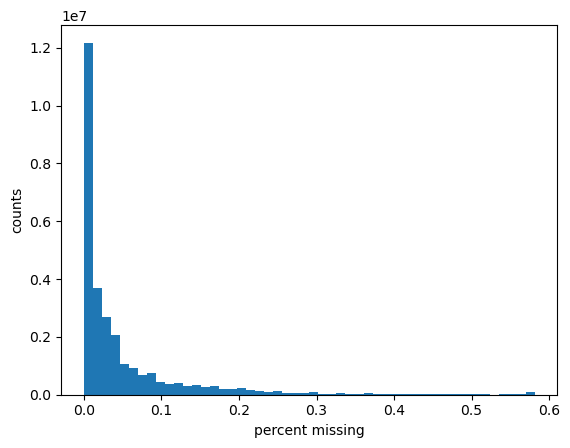

In [769]:
plt.hist(site_df["F_MISS"], bins=50)
plt.ylabel("counts")
plt.xlabel("percent missing")
plt.show()

In [790]:
site_df['id'] = site_df['CHR'].astype(str) + ":" + site_df['POS'].astype(str)
site_df

,CHR,POS,N_DATA,N_GENOTYPE_FILTERED,N_MISS,F_MISS,id
0,NC_067196.1,124230,282,0,135,0.478723,NC_067196.1:124230
1,NC_067196.1,124256,282,0,135,0.478723,NC_067196.1:124256
2,NC_067196.1,124262,282,0,135,0.478723,NC_067196.1:124262
3,NC_067196.1,124281,282,0,135,0.478723,NC_067196.1:124281
4,NC_067196.1,124285,282,0,135,0.478723,NC_067196.1:124285
...,...,...,...,...,...,...,...
28524357,NC_067202.1,19478785,282,0,3,0.010638,NC_067202.1:19478785
28524358,NC_067202.1,19478806,282,0,3,0.010638,NC_067202.1:19478806
28524359,NC_067202.1,19478807,282,0,3,0.010638,NC_067202.1:19478807
28524360,NC_067202.1,19478810,282,0,3,0.010638,NC_067202.1:19478810


In [791]:
len(remove_list)

2642062

In [793]:
remove_df = site_df.loc[site_df["F_MISS"] >= 0.15]
remove_df[["CHR", "POS"]].to_csv("remove.list", sep="\t", index=False, header=False)

# remove_list = list(remove_df["id"].values)
# np.savetxt("remove.list", remove_list, delimiter=',', fmt="%s")

In [ ]:
%%bash

vcftools \
    --vcf removed_junctions_sh.vcf \
    --exclude-positions remove.list \
    --recode \
    --recode-INFO-all \
    --stdout \
    >high_freq_sh.vcf

# FST

In [794]:
callset=allel.read_vcf('high_freq_sh.vcf')

In [795]:
gt      = allel.GenotypeArray(callset['calldata/GT'])
chroms  = callset["variants/CHROM"]
samples = callset["samples"]
poss    = callset["variants/POS"]
var_ids = callset["variants/ID"]

uniq_chroms=np.unique(chroms)

In [796]:
#get kmeans_pop_idxs

#now get an index for each sample/population
samples = list(callset["samples"])

#initiate list that will store the vcf idx for each sample in relation to the pca k group
kmeans_pop_idxs = defaultdict(lambda: [])

for sample in samples:
    idx=samples.index(sample)
    pop=pca_df.loc[pca_df["sample_name"] == sample, "kmeans_label"].values[0]
    kmeans_pop_idxs[pop].append(idx)

In [797]:
nw=kmeans_pop_idxs["sh_nw"]
se=kmeans_pop_idxs["sh_se"]

In [798]:
a, b, c = allel.weir_cockerham_fst(gt, [nw, se])
fst = np.sum(a) / (np.sum(a) + np.sum(b) + np.sum(c))
print(fst)

0.15603580347508206


In [800]:
fsts, ses, vbs, vjs = allel.average_weir_cockerham_fst(gt, 
                                                       [nw, se], 
                                                       5000, 
                                                       max_allele=None)
fsts

0.15603580347508206

In [828]:
chrs=[]
fsts=[]
starts=[]
stops=[]

minus_sb_df = pd.DataFrame()

for chrom in uniq_chroms:
    mask = (chroms == chrom)
    
    chrom_gt  = gt[mask]
    chrom_pos = poss[mask]
    
    #get windows:
    indices = np.arange(0, len(chrom_pos), 500)  # We use the length of chrom_pos to generate indices

    # Initialize empty lists to hold the start and stop positions
    chr_starts = []
    chr_stops = []

    # Create start and stop positions using the indices
    for i in indices[:-1]: # Exclude the last index to avoid short windows
        chr_start = chrom_pos[i]  # Start position is the current index
        chr_starts.append(chr_start)

        # Stop position is the index 500 steps ahead, it always exists because we excluded the last index
        chr_stop = chrom_pos[i + 500]
        chr_stops.append(chr_stop)

    # Convert lists to numpy arrays for consistency with previous code
    chr_starts = np.array(chr_starts)
    chr_stops = np.array(chr_stops)

    fst = allel.moving_weir_cockerham_fst(chrom_gt, [kmeans_pop_idxs["sh_nw"], kmeans_pop_idxs["sh_se"]], size=500)
    
    chrs.extend([chrom] * len(fst))
    fsts.extend(fst)
    starts.extend(chr_starts)
    stops.extend(chr_stops)
   
minus_sb_df["chr"] = chrs
minus_sb_df["starts"]=starts
minus_sb_df["stops"]=stops
minus_sb_df["fst"]=fsts

minus_sb_df.to_csv("fst_minus_introgressed_alleles_df.csv", header=True, sep=",", index=False)

In [829]:
minus_sb_df

,chr,starts,stops,fst
0,NC_067196.1,2199875,2204146,0.122103
1,NC_067196.1,2204146,2209932,0.160502
2,NC_067196.1,2209932,2218263,0.132417
3,NC_067196.1,2218263,2224273,0.183270
4,NC_067196.1,2224273,2232283,0.252160
...,...,...,...,...
51756,NC_067202.1,19455306,19458791,0.028311
51757,NC_067202.1,19458791,19464352,0.020060
51758,NC_067202.1,19464352,19466983,0.045178
51759,NC_067202.1,19466983,19469892,0.057169


In [830]:
# Calculate the genomic position for each data point
chrom_lengths = minus_sb_df.groupby("chr")["stops"].max()
chrom_offsets = chrom_lengths.cumsum().shift(1).fillna(0)
minus_sb_df["genomic_position"] = minus_sb_df["chr"].map(chrom_offsets).astype(int) + minus_sb_df["stops"]
minus_sb_df=minus_sb_df.sort_values("genomic_position").reset_index(drop=True)
minus_sb_df

,chr,starts,stops,fst,genomic_position
0,NC_067196.1,2199875,2204146,0.122103,2204146
1,NC_067196.1,2204146,2209932,0.160502,2209932
2,NC_067196.1,2209932,2218263,0.132417,2218263
3,NC_067196.1,2218263,2224273,0.183270,2224273
4,NC_067196.1,2224273,2232283,0.252160,2232283
...,...,...,...,...,...
51756,NC_067202.1,19455306,19458791,0.028311,300637382
51757,NC_067202.1,19458791,19464352,0.020060,300642943
51758,NC_067202.1,19464352,19466983,0.045178,300645574
51759,NC_067202.1,19466983,19469892,0.057169,300648483


In [831]:
minus_sb_df.to_csv("fst_minus_introgressed_alleles_df.csv", header=True, sep=",", index=False)

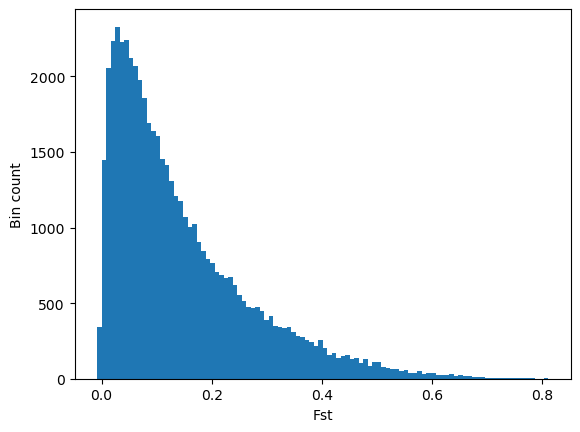

In [827]:
plt.hist(minus_sb_df["fst"], bins=100)
plt.xlabel("Fst")
plt.ylabel("Bin count")

# Save the plot
plt.savefig('fst_minus_introgressed_sb_histogram.svg', format='svg')
plt.savefig('fst_minus_introgressed_sb_histogram.png', dpi=300, format='png')

plt.show()

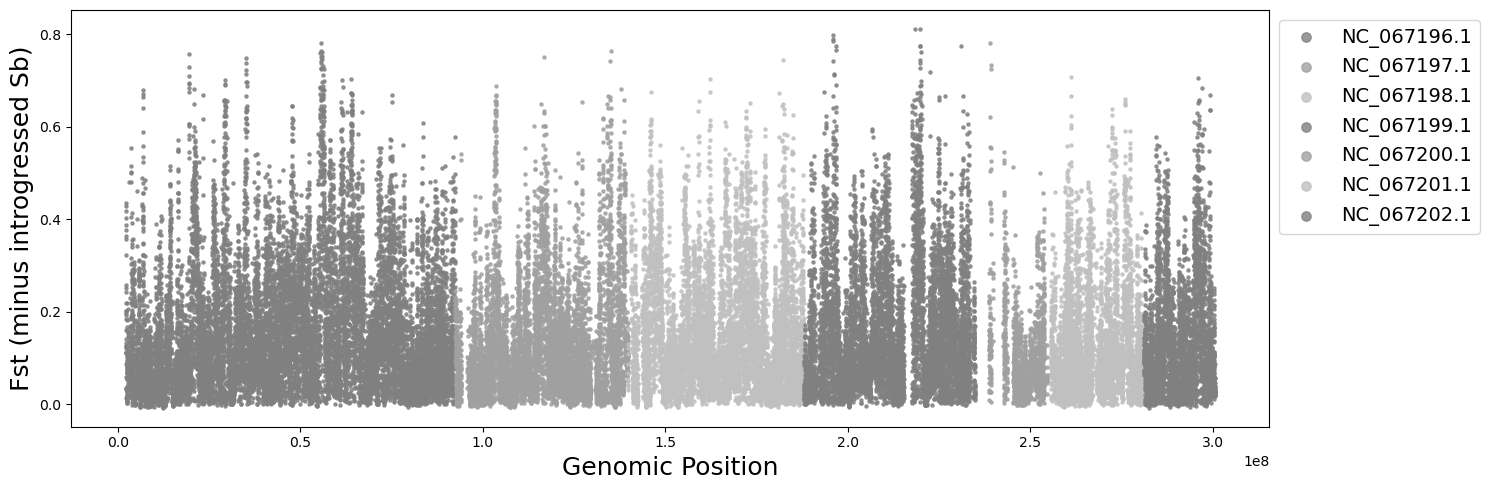

In [878]:
from matplotlib.colors import ListedColormap

# Create the Manhattan plot figure and axis
fig, ax = plt.subplots(figsize=(15, 5))

# Define three shades of grey
shades_of_grey = ['#808080', '#A0A0A0', '#C0C0C0']

# Create the colormap
custom_cmap = ListedColormap(shades_of_grey)

#plot position of the invadolysin locus
#plt.axvline(x=invad_loc, ymin=-3, ymax=3)

# Iterate through the groups of chromosomes and plot each group with a different color

for i, (chrom, group) in enumerate(minus_sb_df.groupby("chr")):
    color = custom_cmap(i % custom_cmap.N)  # Get a color from the colormap
    ax.scatter(group["genomic_position"], group["fst"], s=5, alpha=0.8, color=color, label=f'{chrom}')

# # Plot the significant data points (Bonferroni corrected) in red
# ax.scatter(sig_bonf["genomic_position"], sig_bonf["xpehh"], s=10, alpha=1, color='red', label='Sig.')

# Set the x-axis and y-axis labels
ax.set_xlabel("Genomic Position", fontsize=18)
ax.set_ylabel("Fst (minus introgressed Sb)", fontsize=18)

# Add the legend outside the plot in the upper right corner
ax.legend(markerscale=3, fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

# Adjust the layout to fit the plot in the figure
plt.tight_layout()

# Show the plot
plt.show()

# Save the plot as an SVG file
fig.savefig('fst_minus_introgressed_sb_genome_wide.svg', format='svg')

# Save the plot as a 300 dpi PNG file
fig.savefig('fst_minus_introgressed_sb_genome_wide.png', dpi=300, format='png')


# Nucletide diversity (PI)

In [838]:
window_kb_size = 10

In [836]:
acs={}
acs["sh_nw"] = gt.count_alleles(subpop=kmeans_pop_idxs["sh_nw"])
acs["sh_se"] = gt.count_alleles(subpop=kmeans_pop_idxs["sh_se"])

In [842]:
stat_dfs=defaultdict(lambda: pd.DataFrame(columns=["pi", "start", "stop", "n_bases", "n_snps", "chrom"]))

pops=["sh_nw", "sh_se"]

for pop in pops:
    for chrom in tqdm(uniq_chroms):
        chrom_pos = poss[chroms == chrom]
        chrom_ac =  acs[pop][chroms == chrom]
        
        if len(chrom_ac) > 10:

            try:
                pi, windows, nbases, counts = allel.windowed_diversity(chrom_pos, chrom_ac, window_kb_size*1_000)

                #add info to a df
                chr_df=pd.DataFrame([pi,windows[:,0], windows[:,1], nbases, counts]).T
                chr_df.columns=["pi", "start", "stop", "n_bases", "n_snps"]
                chr_df["chrom"]=chrom

                stat_dfs[pop]=pd.concat([stat_dfs[pop], chr_df])

            except:
                print("An exception occurred: {}:{}".format(pop, chrom))
                break

        #reset index
        stat_dfs[pop]=stat_dfs[pop].reset_index(drop=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


In [847]:
pi_df=stat_dfs["sh_nw"]
pi_df["sh_se_pi"] = stat_dfs["sh_se"]["pi"]
pi_df["sh_nw_pi"] = stat_dfs["sh_nw"]["pi"]
pi_df.drop('pi', axis=1, inplace=True)
pi_df

,start,stop,n_bases,n_snps,chrom,sh_se_pi,sh_nw_pi
0,2199875.0,2209874.0,10000.0,991.0,NC_067196.1,0.002530,0.001129
1,2209875.0,2219874.0,10000.0,527.0,NC_067196.1,0.003361,0.002571
2,2219875.0,2229874.0,10000.0,893.0,NC_067196.1,0.009734,0.006369
3,2229875.0,2239874.0,10000.0,1089.0,NC_067196.1,0.015190,0.013316
4,2239875.0,2249874.0,10000.0,807.0,NC_067196.1,0.010925,0.009556
...,...,...,...,...,...,...,...
29455,19430286.0,19440285.0,10000.0,515.0,NC_067202.1,0.002791,0.002696
29456,19440286.0,19450285.0,10000.0,118.0,NC_067202.1,0.000644,0.000657
29457,19450286.0,19460285.0,10000.0,666.0,NC_067202.1,0.006323,0.007064
29458,19460286.0,19470285.0,10000.0,1401.0,NC_067202.1,0.011685,0.010940


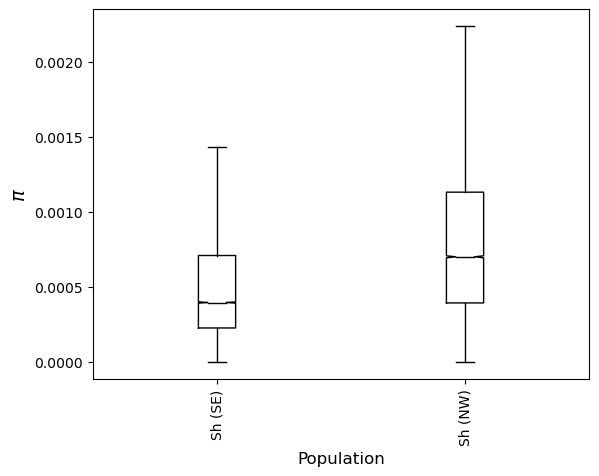

In [880]:
plt.boxplot([ pi_df.dropna(subset=["sh_se_pi"])["sh_se_pi"],
              pi_df.dropna(subset=["sh_nw_pi"])["sh_nw_pi"] ],
            
             showfliers=False, 
             notch=True,
             labels=["Sh (SE)", "Sh (NW)" ],

             medianprops=dict(color="black", lw=1))

plt.xticks(rotation=90)
plt.xlabel("Population", fontsize=12)
plt.ylabel("$\pi$", fontsize=14)
plt.savefig('pi_minus_introgressed_sb.png', dpi=300, format='png')
plt.savefig("pi_minus_introgressed_sb.svg")
plt.show()


In [881]:
print(f"pop\tmean_pi\tstdev")

for pop in ["nw", "se"]:
    mean_pi = pi_df.dropna(subset=[f"sh_{pop}_pi"])[f"sh_{pop}_pi"].mean()
    std = pi_df.dropna(subset=[f"sh_{pop}_pi"])[f"sh_{pop}_pi"].std()
    print(f"{pop}\t{mean_pi}\t{std}")

pop	mean_pi	stdev
nw	0.0010697158262708692	0.0015742517868021662
se	0.0009257310315234914	0.0018537347112430064


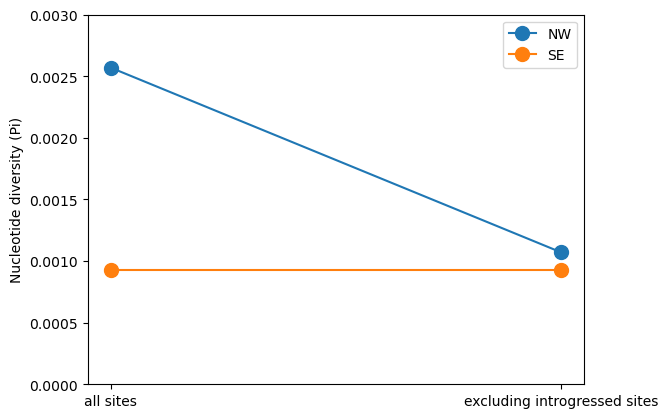

In [882]:
pi_all_nw=0.0025703585831520176
pi_none_nw=0.0010697158262708692

pi_all_se=0.0009257310315234914
pi_none_se=0.0009257310315234914

x=[1,2]
nw=[pi_all_nw, pi_none_nw]
se=[pi_all_se, pi_none_se]

plt.plot(x, nw, label="NW", marker='o', markersize=10)
plt.plot(x, se, label="SE", marker='o', markersize=10)
plt.xticks([1, 2], ["all sites", "excluding introgressed sites"])
plt.ylabel("Nucleotide diversity (Pi)")
plt.legend()
plt.ylim([0, 0.003])

plt.savefig('change_in_pi_vs_introgressed.svg',)
plt.savefig('change_in_pi_vs_introgressed.png', dpi=300, format='png')

plt.show()


In [875]:
pi_none_nw/pi_all_nw

0.4161737717385261